# 0.0 IMPORTS

In [92]:
import math
import datetime
import pandas as pd
import numpy as np
import inflection
import seaborn as sns

from boruta import BorutaPy
from scipy import stats as ss
from tabulate import tabulate
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.core.display import HTML
from IPython.display import Image

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

## 0.1 Helper Functions

In [2]:
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )


def ml_error ( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt(mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {'Model Name': model_name,
                         'MAE' : mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False ) 
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# Juntando as informações dos DataFrame
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
955947,63,7,2013-02-24,0,0,0,0,0,0,c,c,3700.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov"


# 1.0. Passo 01 - DESCRICAO DOS DADOS

## 1.1. Rename Columns

In [5]:
df1 = df_raw.copy()

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )


cols_new = list( map (snakecase, cols_old) )

#Rename
df1.columns = cols_new

In [7]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [8]:
print(f'Numero de Linhas: {df1.shape[0]}')
print(f'Numero de Colunas: {df1.shape[1]}')

Numero de Linhas: 1017209
Numero de Colunas: 18


## 1.3. Data Types 

In [9]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
df1['date'] = pd.to_datetime( df1['date'])

In [11]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [13]:
df1['competition_distance'].max()

75860.0

In [14]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1 )

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1 )

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'Mai', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types 

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int ) 
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical 

In [19]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [20]:
# Tendencia Central - media, mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean) ).T  # media
ct2 = pd.DataFrame( num_attributes.apply( np.median) ).T # mediana


# Disperção - desvio padrão, min, max, intervalo, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std) ).T                              # desvio padrão
d2 = pd.DataFrame( num_attributes.apply( min ) ).T                           # minimo
d3 = pd.DataFrame( num_attributes.apply( max ) ).T                           # maximo
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T     # intervalo
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T              # skew
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T          # kurtosis

# Concatenar os resultados
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['Atributos', 'min', 'max', 'intervalo', 'media', 'mediana', 'std', 'skew', 'kurtosis']

In [21]:
m

,Atributos,min,max,intervalo,media,mediana,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Attributes

In [22]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

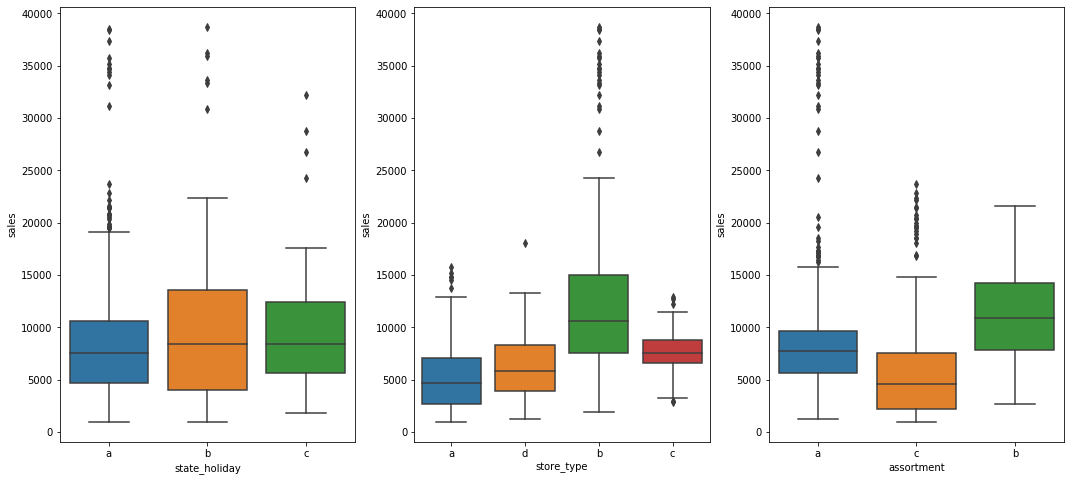

In [23]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]
plt.figure(figsize=(18, 8))

plt.subplot( 1, 3, 1)
sns.boxplot(x='state_holiday' ,y='sales' , data=aux1 )

plt.subplot( 1, 3, 2)
sns.boxplot(x='store_type' ,y='sales' , data=aux1 )

plt.subplot( 1, 3, 3)
sns.boxplot(x='assortment' ,y='sales' , data=aux1 )

# 2.0. Passo 02 - FEATURE ENGENEERING 

In [24]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

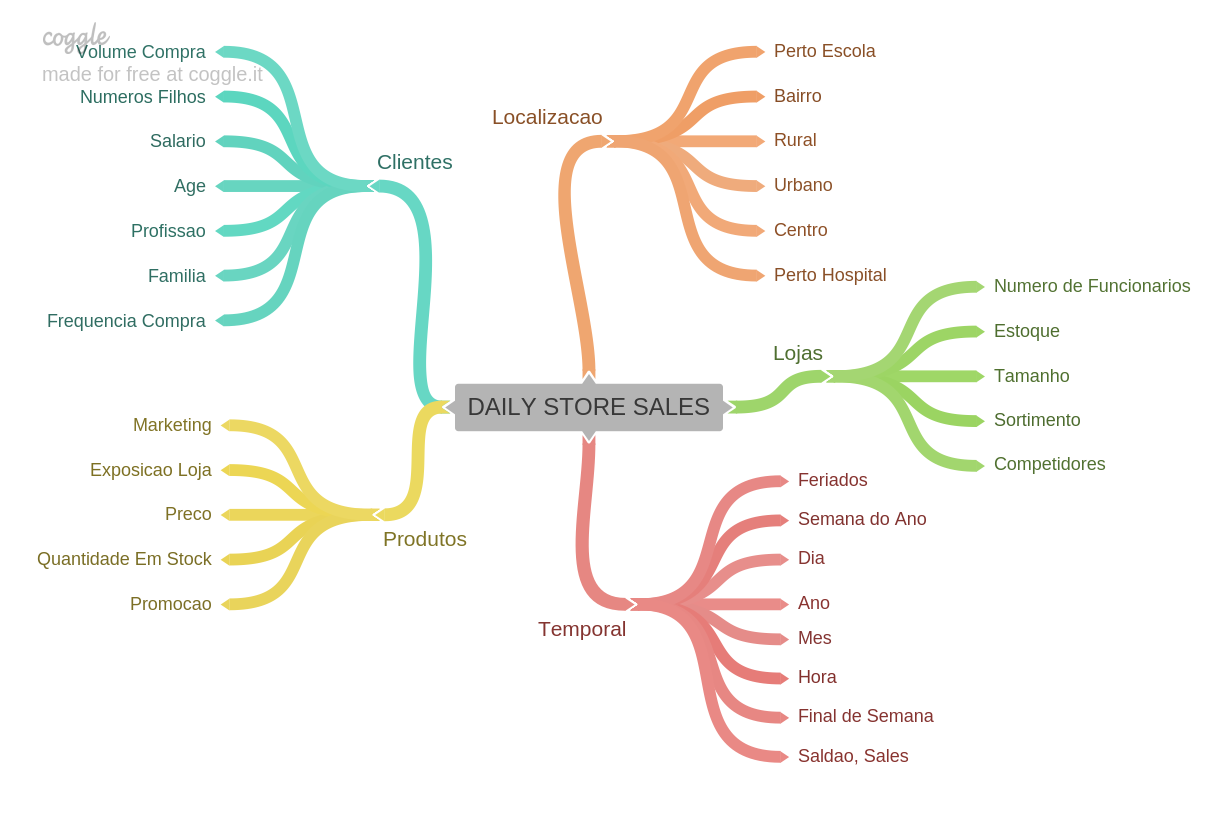

In [25]:
Image( 'img/MindMapHypothesis.png' )

## 2.2. Criação das Hipoteses

### 2.2.1. Hipoteses Lojas

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Temporal

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [26]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )


# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x:datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [27]:
df2.sample(5).T

,165207,643851,188897,756139,731355
store,188,167,463,955,701
day_of_week,4,7,4,5,6
date,2015-03-05 00:00:00,2013-12-01 00:00:00,2015-02-12 00:00:00,2013-08-23 00:00:00,2013-09-14 00:00:00
sales,6000,0,5626,3225,4551
customers,508,0,940,353,604
open,1,0,1,1,1
promo,1,0,0,0,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,1,0
store_type,d,a,a,d,d


# 3.0. Passo 03 - FILTRAGEM DE VARIÁVEIS

In [28]:
df3 = df2.copy()

In [29]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas 

In [30]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecao das colunas 

In [31]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop( cols_drop, axis=1 )

# 4.0. Passo 04 - ANALISE EXPLORATORIA DOS DADOS

In [32]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

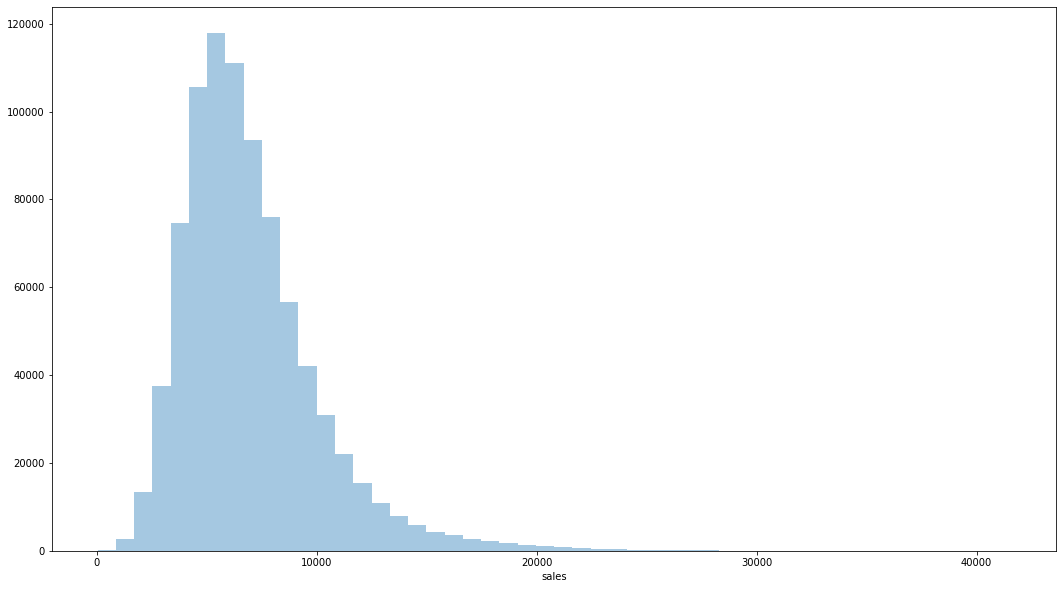

In [33]:
plt.figure(figsize=(18, 10))
sns.distplot( df4['sales'], kde=False )

### 4.1.2. Numerical Variable

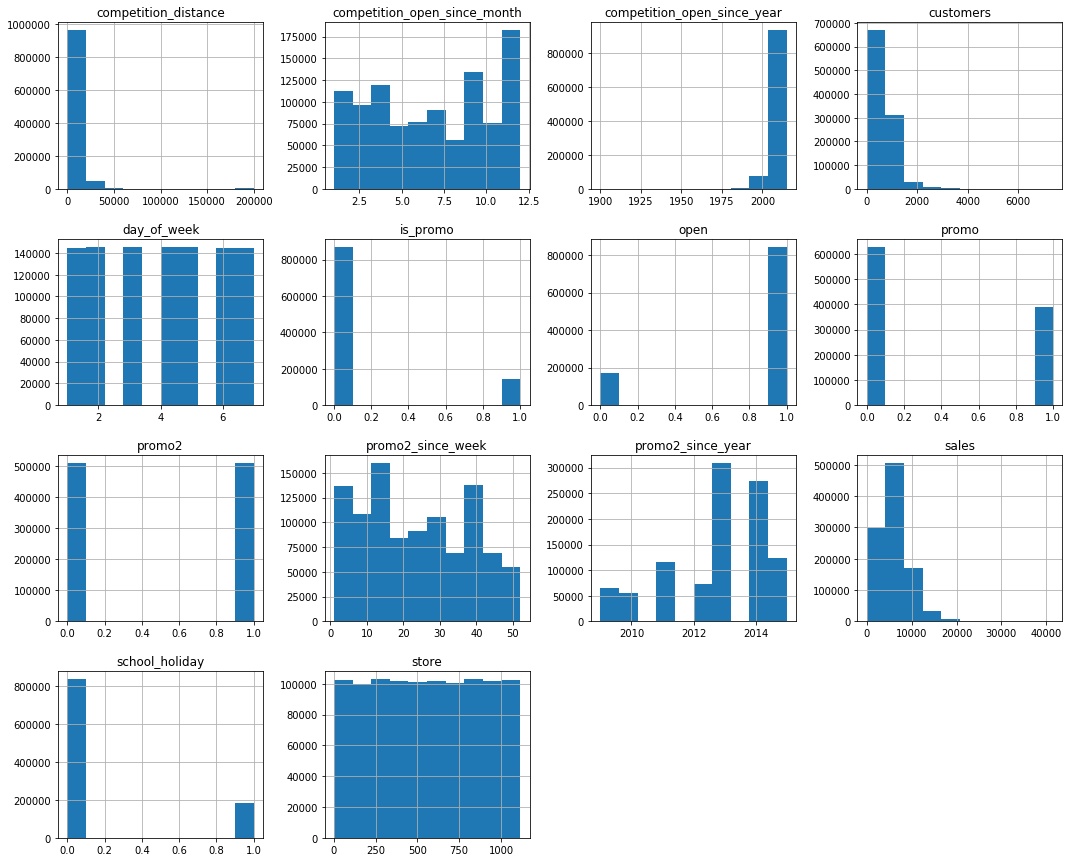

In [34]:
num_attributes.hist(figsize=(18, 15));

### 4.1.3. Categorical Variable

In [35]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

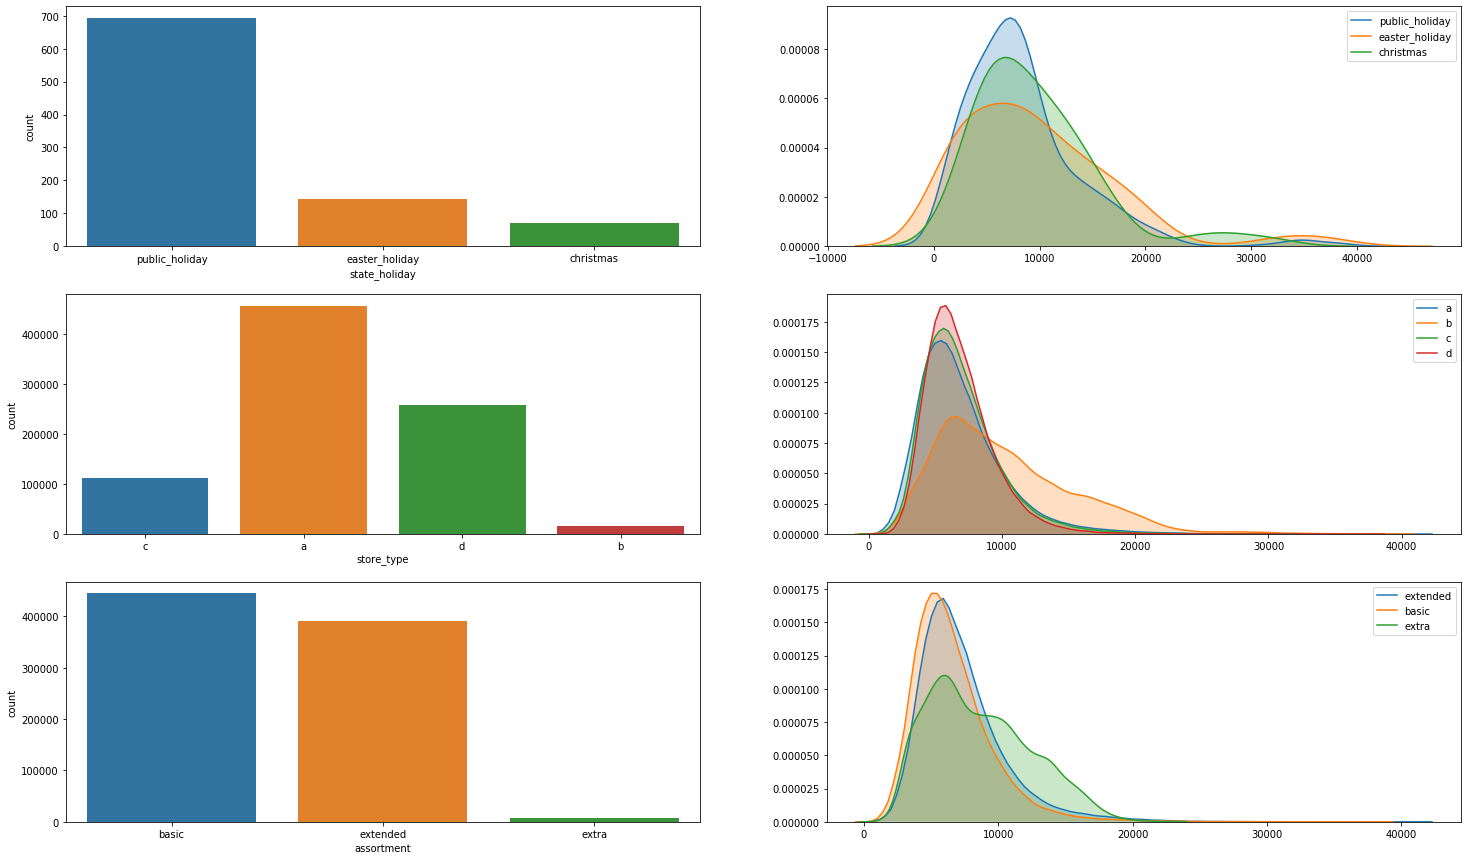

In [36]:
#state_holiday
plt.figure(figsize=(25, 15))
plt.subplot( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

#store_type
plt.subplot( 3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot( 3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

#assortment
plt.subplot( 3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot( 3, 2, 6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )


## 4.2. Analise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.
**FALSA** - Lojas com maior sortimentos vendem MENOS 

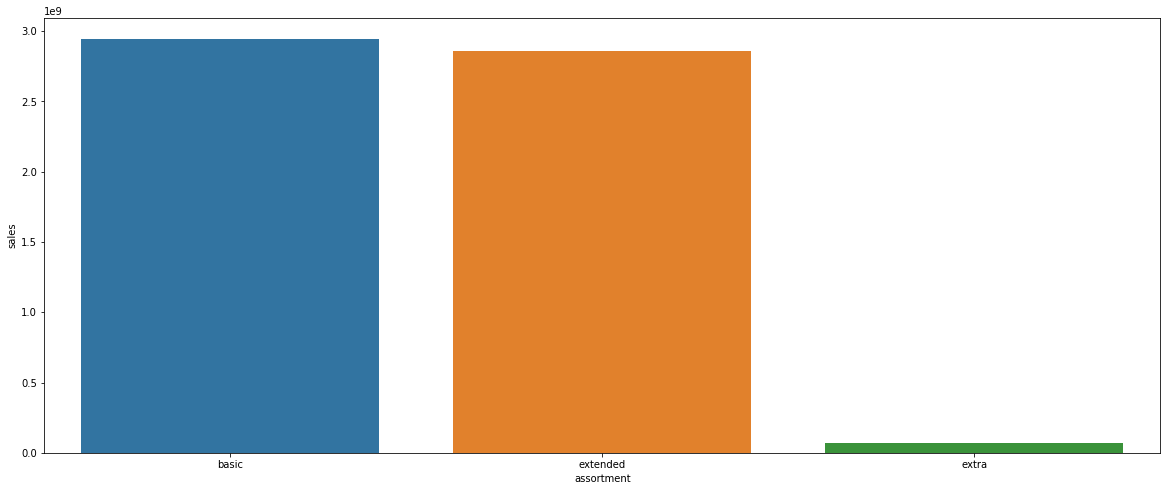

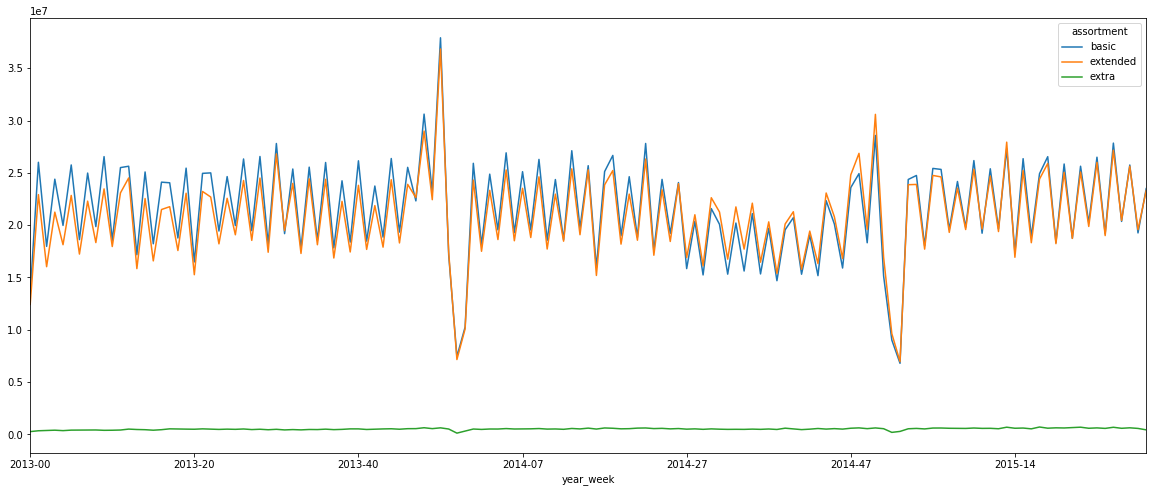

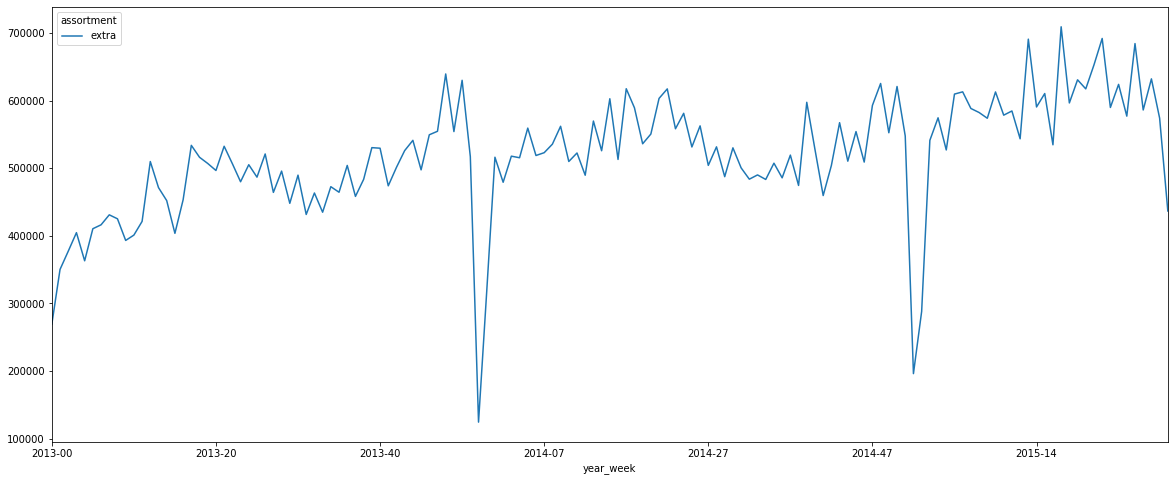

In [37]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()

plt.figure(figsize=(20, 8))
sns.barplot( x='assortment', y='sales', data=aux1);

aux2 = df4[['assortment', 'sales', 'year_week']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot(figsize=(20, 8));

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot(figsize=(20, 8));

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com competidores mais próximos vendem MAIS

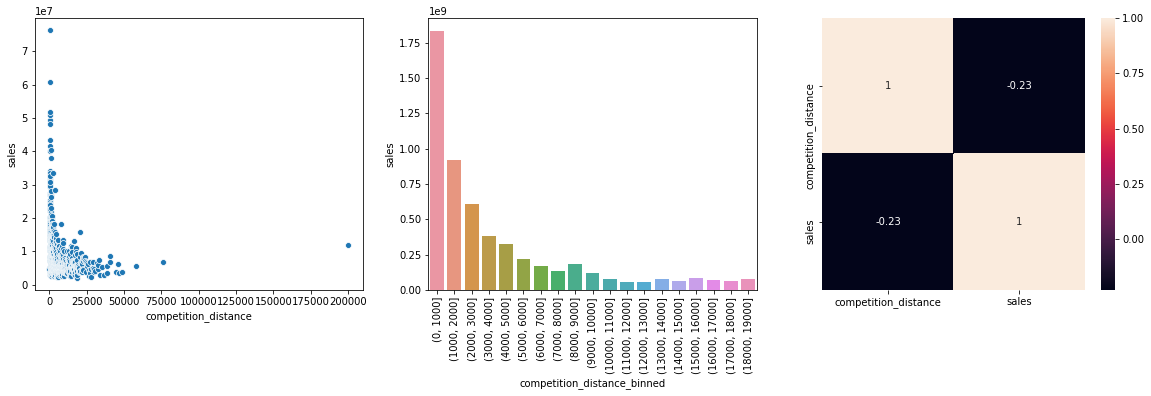

In [38]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.figure(figsize=(20, 5))
plt.subplot( 1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot( 1, 3, 2)
bins = list(np.arange( 0, 20000, 1000 ) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation=90)

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);

### H3. Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA** Lojas competidores à mais tempo vendem MENOS

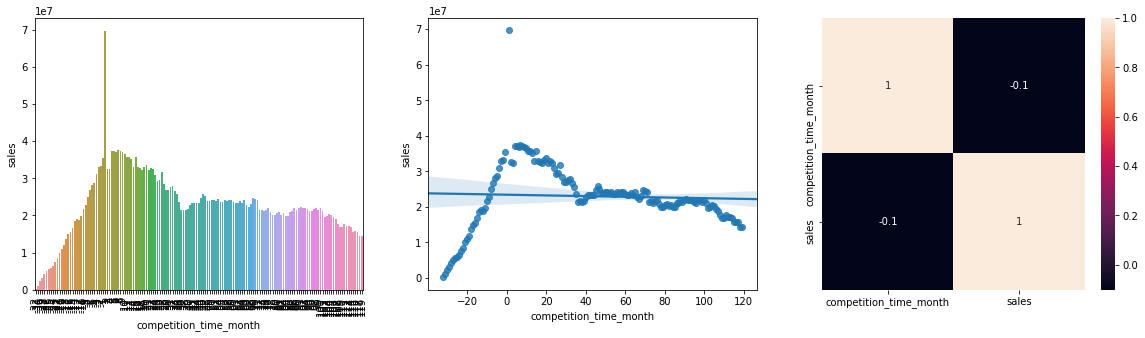

In [39]:
plt.figure(figsize=(20, 5))
plt.subplot( 1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] <120 ) & ( aux1['competition_time_month'] !=0 )]


sns.barplot( x='competition_time_month', y='sales', data=aux2);
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2)
sns.regplot( x='competition_time_month', y='sales', data=aux2);

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodo de promoção

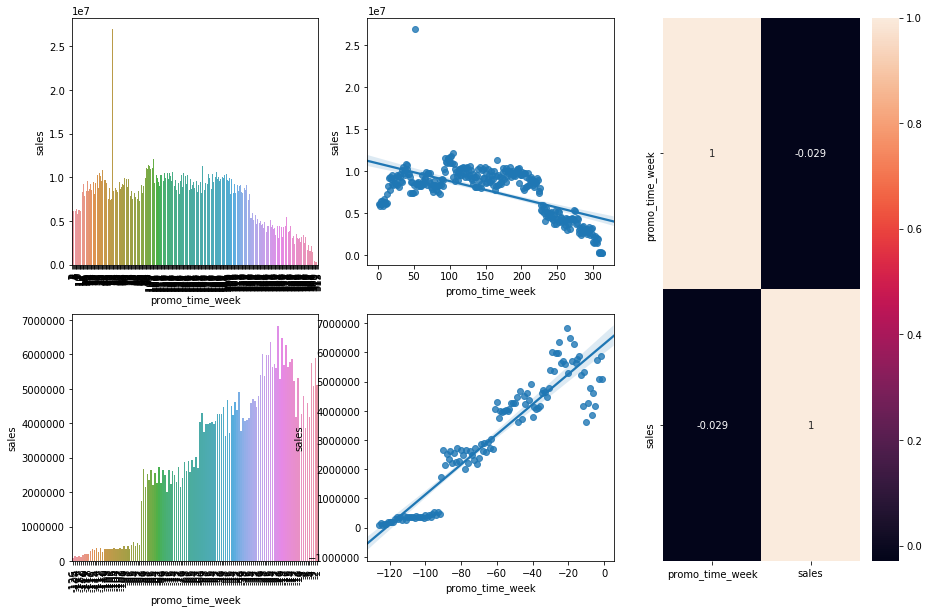

In [40]:
plt.figure(figsize=(15, 10))

aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[ aux1['promo_time_week'] > 0 ] # promoção extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks( rotation=90 );

plt.subplot(  grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);


plt.subplot(  grid[1,0])
aux3 = aux1[ aux1['promo_time_week'] < 0 ] # promoção regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks( rotation=90 );

plt.subplot(  grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(  grid[:,2])
sns.heatmap( aux1.corr( method='pearson'), annot=True );

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem MENOS

<Figure size 1080x720 with 0 Axes>

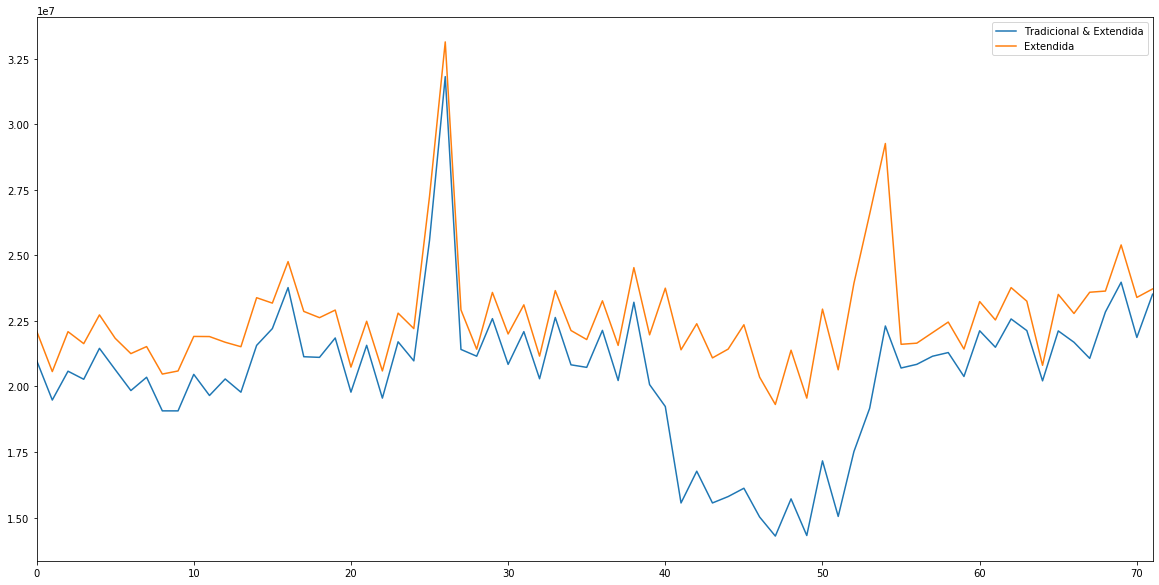

In [41]:
plt.figure(figsize=(15, 10))
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot(figsize=(20, 10));

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax );

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado de Natel vendem MENOS

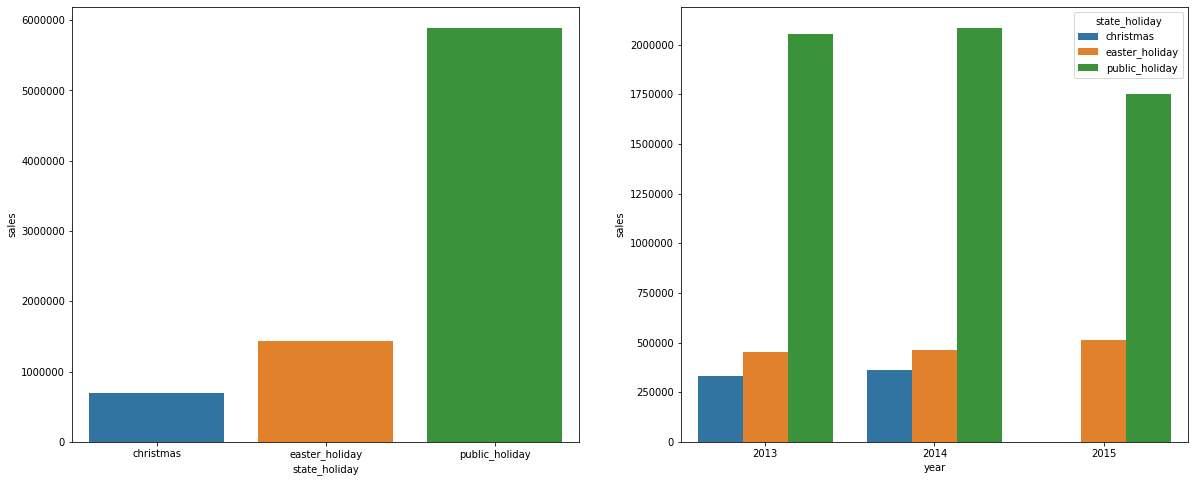

In [42]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

plt.figure(figsize=(20, 8))
plt.subplot( 1, 2, 1)
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );


### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem MENOS ao longo dos anos.

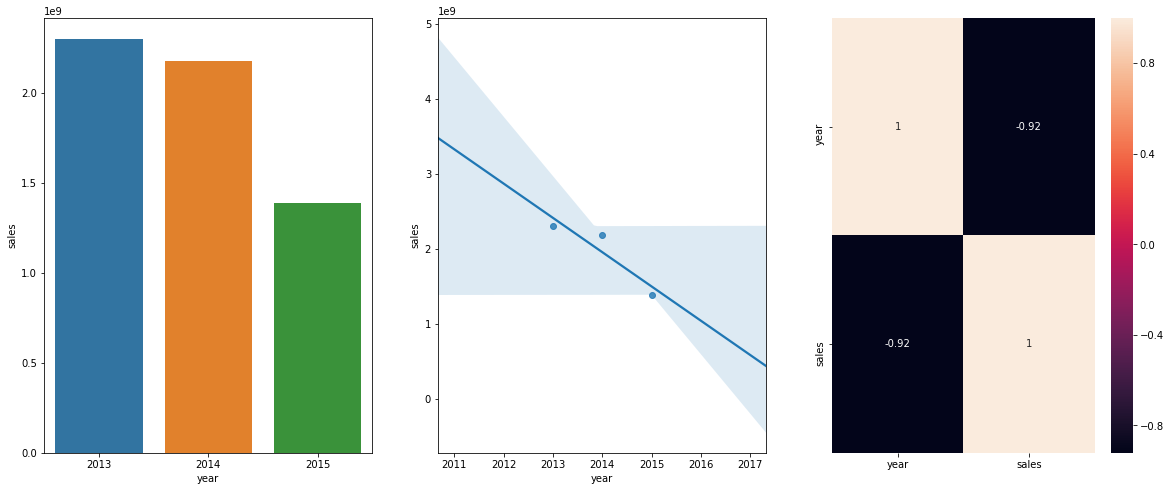

In [43]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(20, 8))
plt.subplot( 1, 3, 1)
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2)
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);

### H9. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem MENOS no segundo semestre do ano.

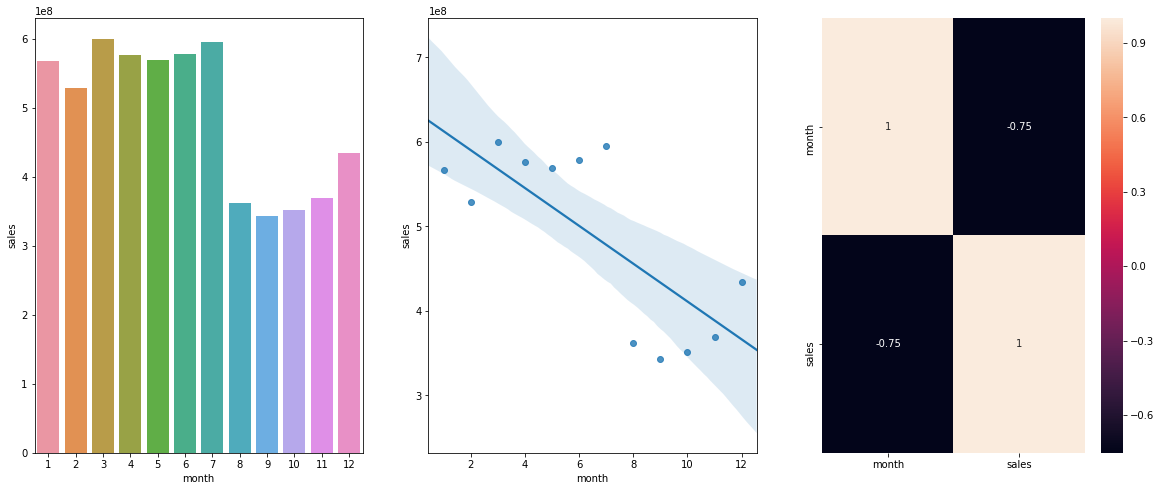

In [44]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(20, 8))
plt.subplot( 1, 3, 1)
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2)
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem MAIS depois do dia 10 de cada mês.

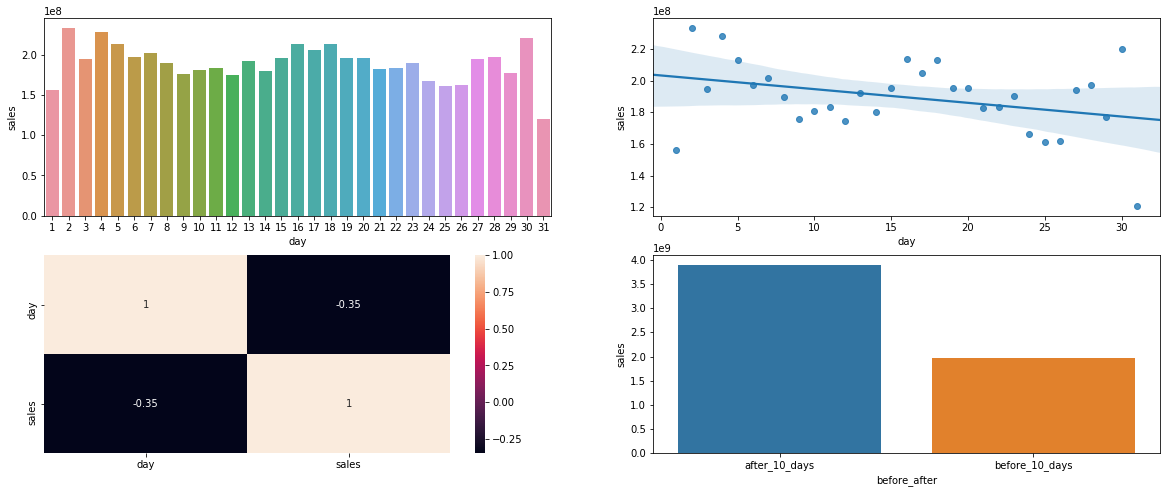

In [45]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(20, 8))
plt.subplot( 2, 2, 1)
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2)
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);

plt.subplot( 2, 2, 4)
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2 );

### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem MENOS aos finais de semana.

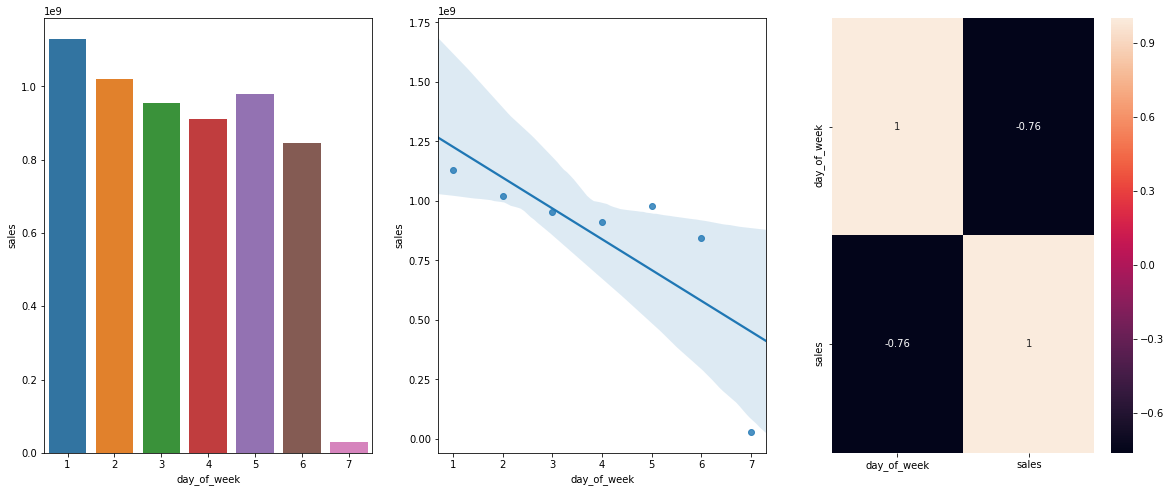

In [46]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(20, 8))
plt.subplot( 1, 3, 1)
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2)
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem MENOS durante os feriados escolares, exceto nos meses de julho e agosto.

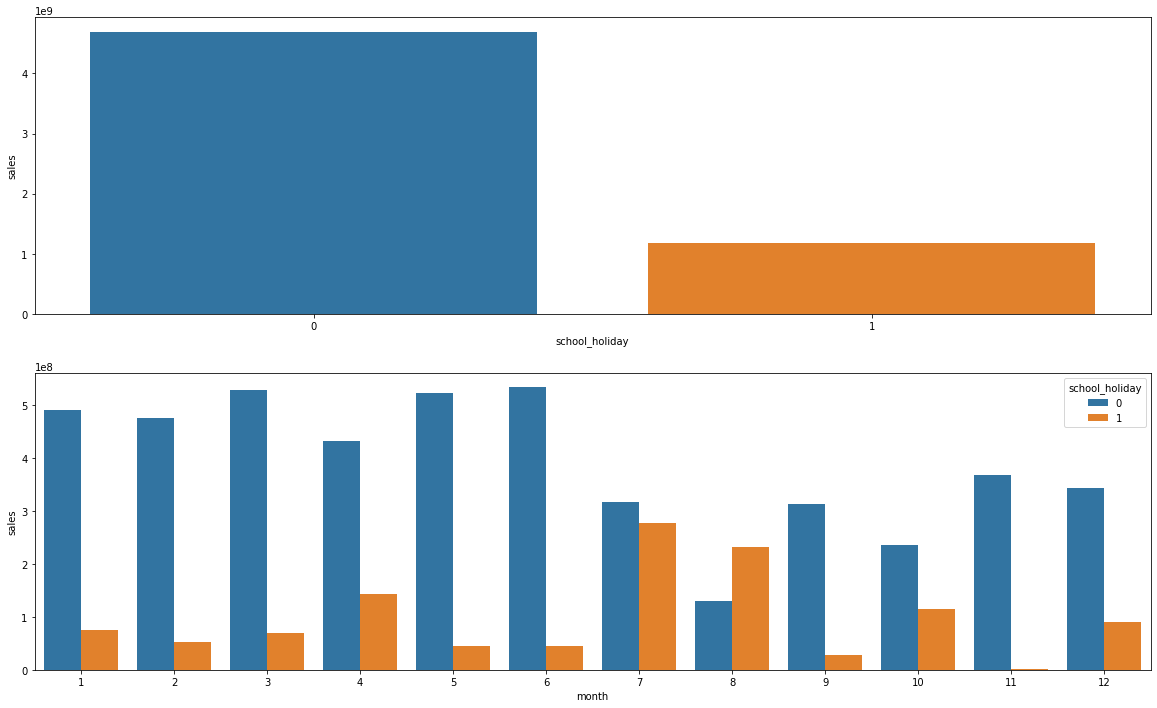

In [47]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.figure(figsize=(20, 12))
plt.subplot( 2, 1, 1)
sns.barplot( x='school_holiday', y='sales', data=aux1 );

plt.subplot( 2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );


### 4.2.1 Resumo das Hipoteses

In [48]:
tab= [['Hipoteses', 'Conclusão', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
      ]

print(tabulate( tab, headers='firstrow'))

Hipoteses    Conclusão    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

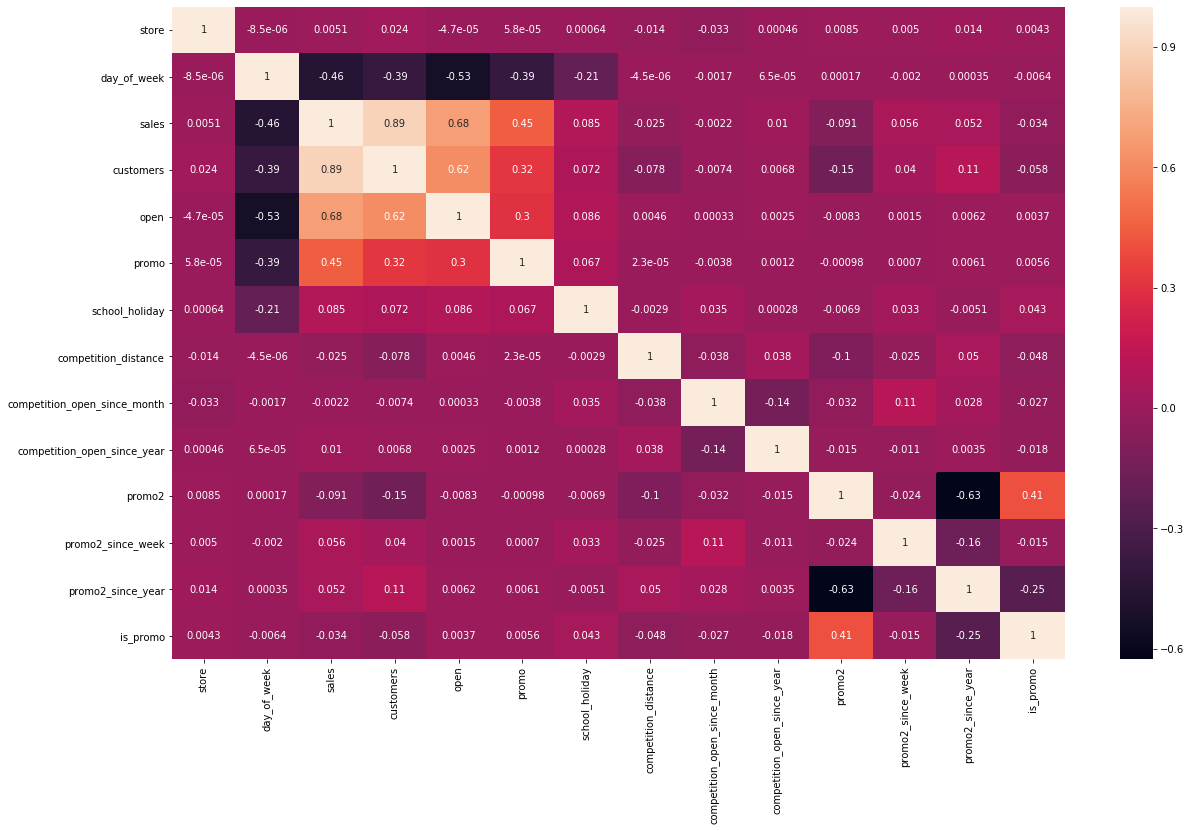

In [49]:
correlation = num_attributes.corr( method='pearson' )
plt.figure(figsize=(20, 12))
sns.heatmap( correlation, annot=True);

### 4.3.2. Categorical Attributes

<ipython-input-2-443eca3d78cd>:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cm = pd.crosstab( x, y ).as_matrix()


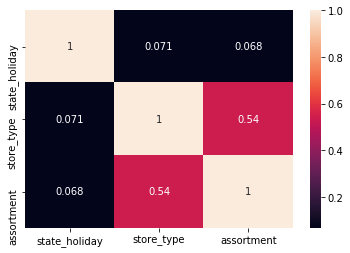

In [50]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 5.0. Passo 05 - PREPARAÇÃO DOS DADOS

In [51]:
df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

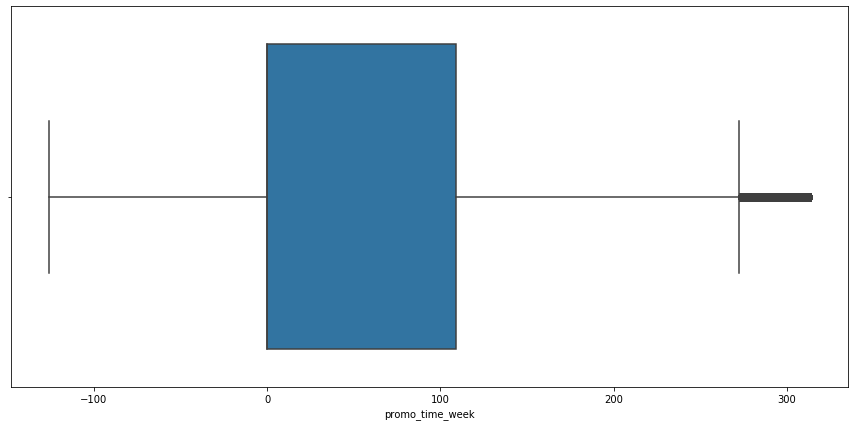

In [52]:
plt.figure(figsize=(15, 7))
sns.boxplot( df5['promo_time_week'] );

In [53]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )


## 5.3. Transformação

### 5.3.1. Encoding

In [54]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,...,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [55]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 
                   'extra': 2, 
                   'extended': 3}

df5['assortment'] = df5['assortment'].map( assortment_dict )

In [56]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2. Transformação da variável resposta

In [57]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Transformação de natureza

In [58]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. *np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. *np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. *np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. *np.pi/30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. *np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. *np.pi/52 ) ) )

In [59]:
df5

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,8.124447,0,1,1,1,-0.351613,9,...,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1016827,733,2,2013-01-01,9.284148,0,1,1,2,-0.237097,10,...,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1016863,769,2,2013-01-01,8.524367,0,1,1,2,-0.240323,1,...,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1017042,948,2,2013-01-01,8.410053,0,1,1,2,-0.145161,1,...,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709


# 6.0. Passo 06 - FEATURE SELECTION

In [72]:
df6 = df5.copy()

## 6.1. Separação DataFrame em treino e teste

In [73]:
cols_drop = ['day_of_week', 'month', 'day', 'week_of_year', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1)

In [74]:
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [75]:
# Dados de treino
X_train = df6[df6['date'] < '2015-06-19' ]
y_train = X_train['sales']

# Dados de teste
X_test = df6[df6['date'] >= '2015-06-19' ]
y_test = X_test['sales']

print(f'Data min treino: {X_train["date"].min()}')
print(f'Data max treino: {X_train["date"].max()}')

print(f'\nData min teste: {X_test["date"].min()}')
print(f'Data max teste: {X_test["date"].max()}')

Data min treino: 2013-01-01 00:00:00
Data max treino: 2015-06-18 00:00:00

Data min teste: 2015-06-19 00:00:00
Data max teste: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [76]:
# training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1. Best Feature from Boruta

In [77]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [78]:
X_train.columns

Index(['store', 'date', 'sales', 'promo', 'school_holiday', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'competition_time_month',
       'promo_time_week', 'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos'],
      dtype='object')

In [79]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. Passo 07 - MACHINE LEARNING MODELLING

In [80]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1. Avarege Model

In [87]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[[ 'store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Avarege Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarege Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [91]:
# model
lr = LinearRegression().fit( x_train, y_train)

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## 7.3. Linear Regression Regularized Model - Lasso

In [93]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train)

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
